In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
gdf = gpd.read_file("Full Constituency Data.gpkg")

In [3]:
name_fix = {'Lab':'lab', 'Con':'con', 'LDem':'ld', 'Ref':'ref', 'Grn':'grn', 'Oth':'other', 'SNP':'snp', 'PC':'pc', np.nan:"other"}

In [4]:
bpdf = pd.read_csv("Models/BritainElectsModel.csv")

bpdf.Win = bpdf.Win.map(name_fix)

In [5]:
for party in ["Lab", "Con", "LDem", "Grn", "SNP", "PC", "Ref", "Ind_Oth"]:
    bpdf[party] = bpdf[party].str[:-1].astype(float)

In [6]:
bpdf.fillna(0, inplace=True)

In [7]:
bpdf.rename(columns={"Constituency":"constituency"}, inplace=True)
df = pd.merge(gdf, bpdf, on="constituency")

In [8]:
party_colours = {"con":"#0087DC", "lab":"#E4003B", "ld":"#FAA61A", "grn":"#02A95B", "ref":"#12B6CF", "snp":"#FDF38E", "pc":"#005B54", "other":"#DCDCDC", np.nan:"#DCDCDC"}

In [9]:
df.rename(columns={"con_%_2019":"con_2019_%", "lab_%_2019":"lab_2019_%", "ld_%_2019":"ld_2019_%", "grn_%_2019":"grn_2019_%"}, inplace=True)

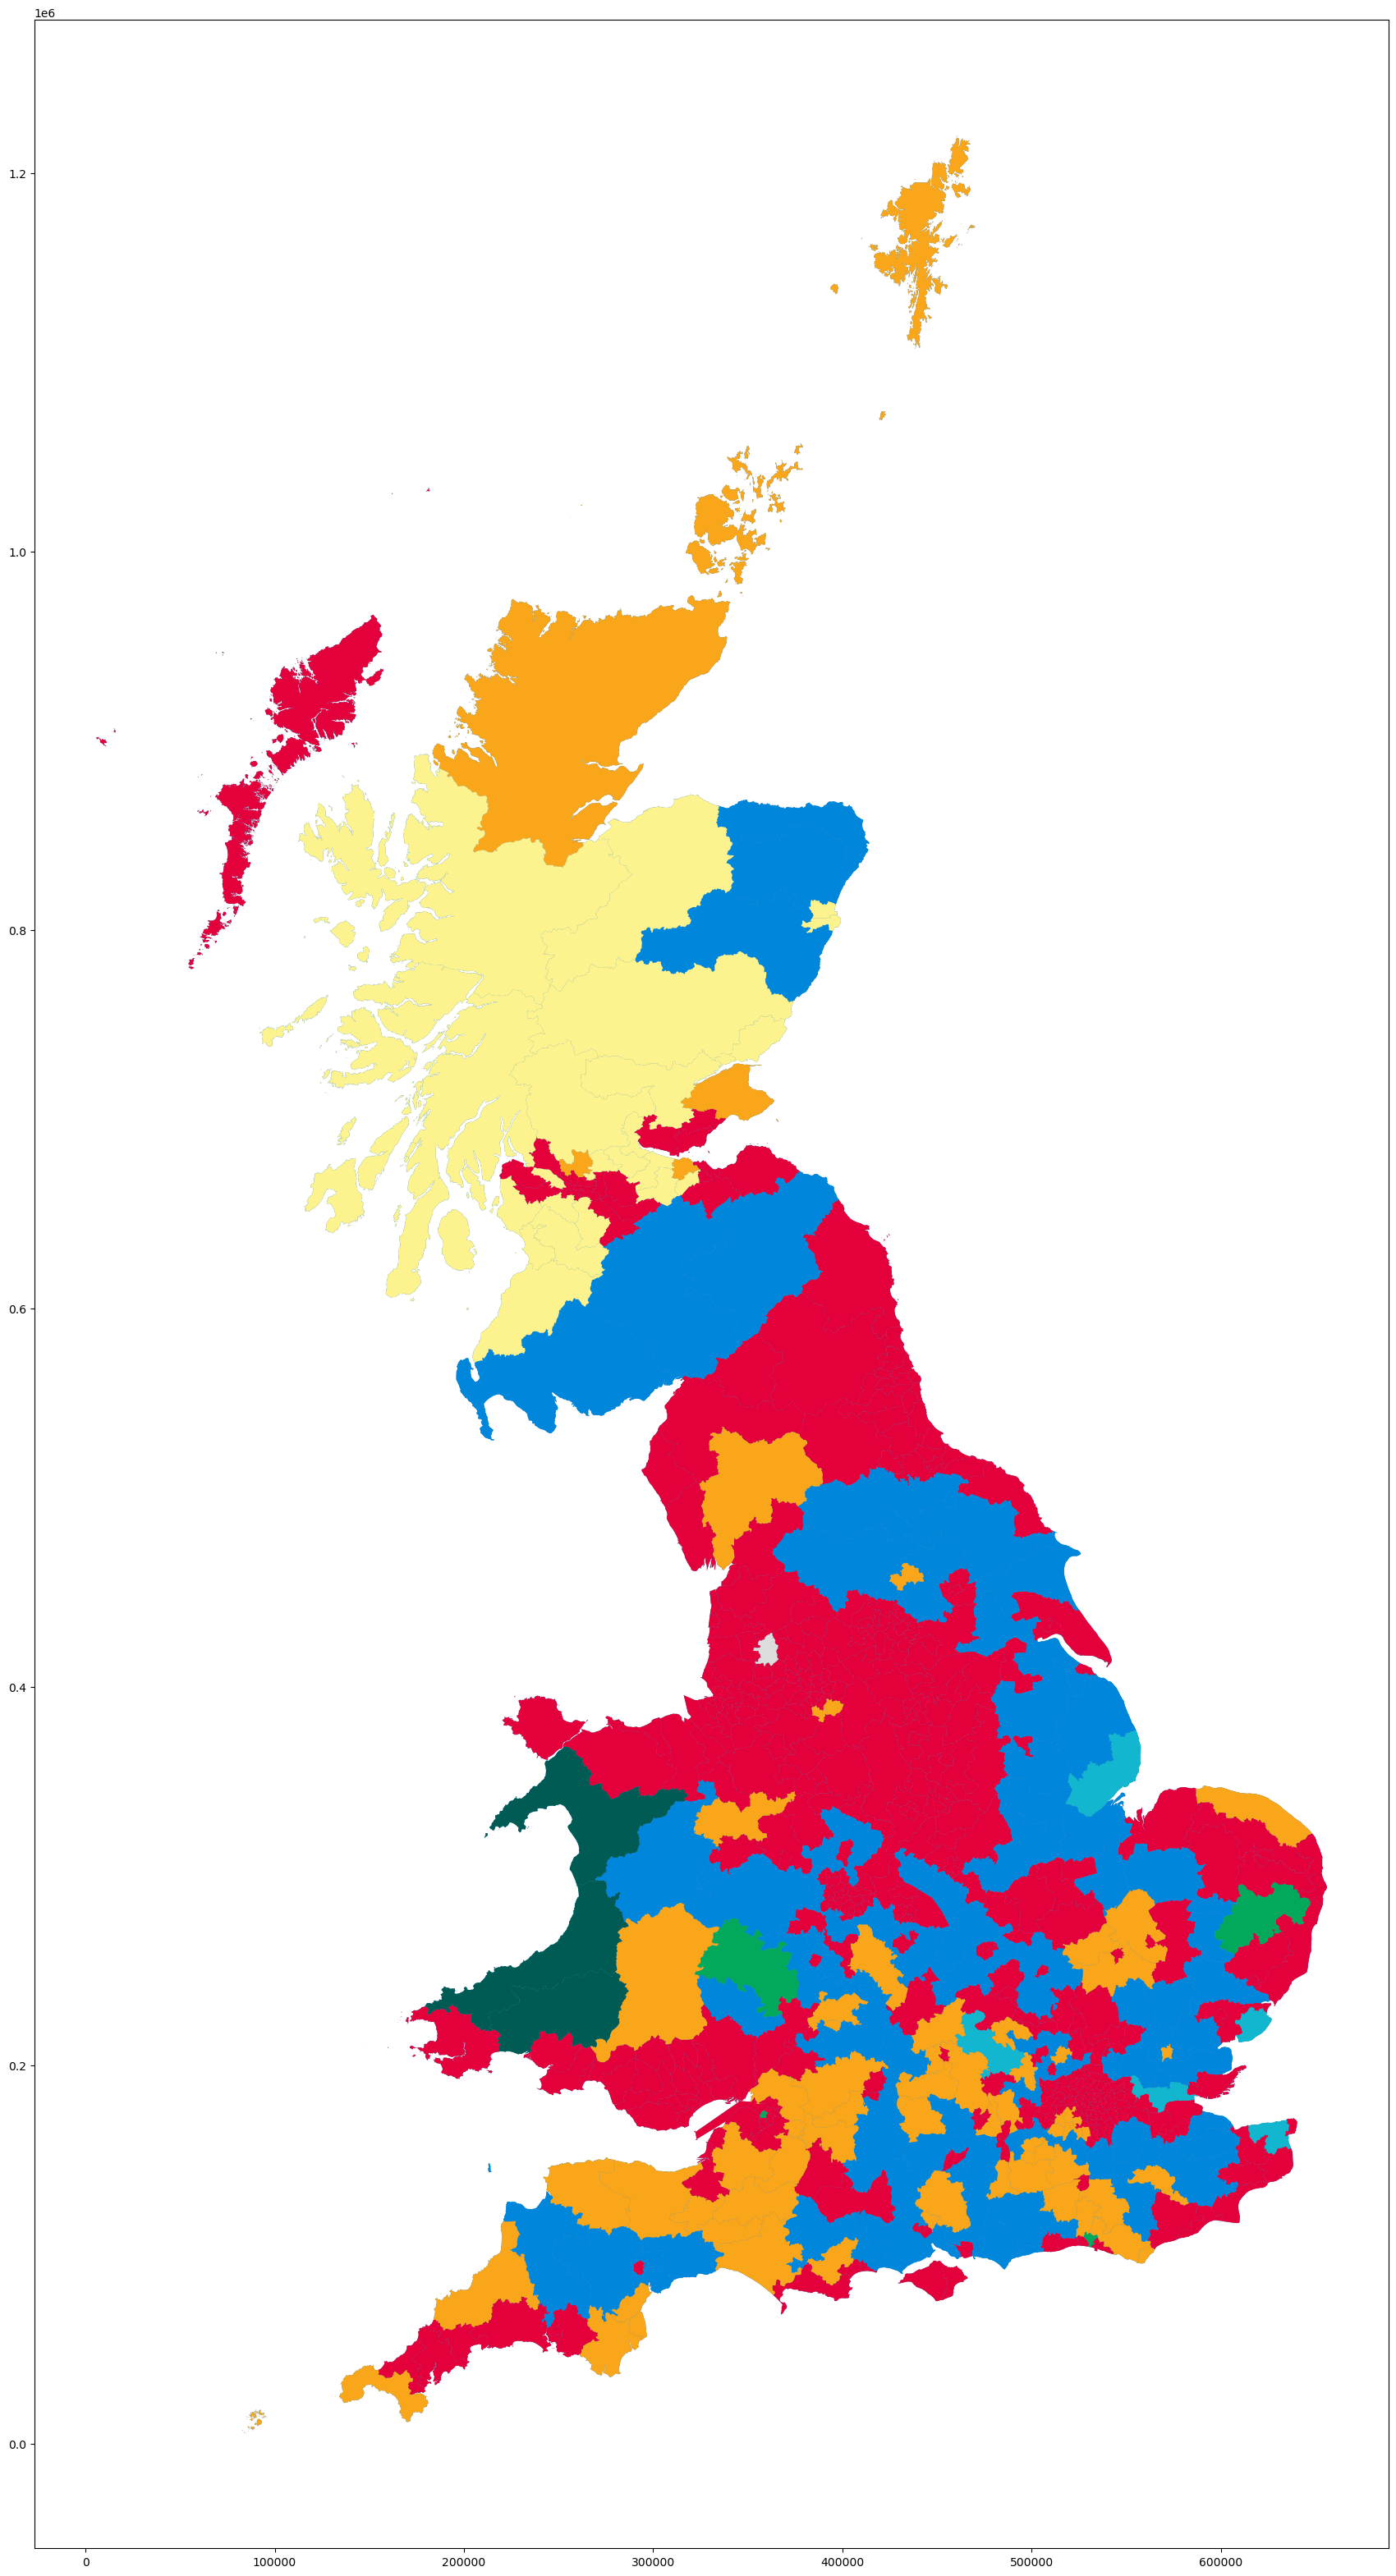

In [12]:
ax = df.plot(color=None, figsize=(40,40), edgecolor=None)
for party in df.Win.unique():
    df[df.Win == party].plot(ax=ax, color=party_colours[party], edgecolor=None)

In [13]:
scale_cols = ['LAT', 'LONG',
       'turnout', 'con_2019_%', 'lab_2019_%', 'ld_2019_%',
       'grn_2019_%', 'ref_2019_%', 'snp_2019_%', 'pc_2019_%', 'other_2019_%', 'Total population',
       'Number of households', 'Aged 15 years and under',
       'Aged 16 to 24 years', 'Aged 25 to 34 years', 'Aged 35 to 49 years',
       'Aged 50 to 64 years', 'Aged 65 years and over', 'United Kingdom',
       'Ireland', 'Other Europe', 'Africa', 'Middle East and Asia',
       'Americas and the Caribbean', 'Australasia and others', 'White British',
       'Other White', 'Asian / Asian British', 'Black / Black British',
       'Mixed / Multiple ethnic groups', 'Other ethnic groups', 'No religion',
       'Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'Other religion', 'Not answered', 'Owned outright',
       'Owned with a mortgage or loan', 'Private rented', 'Social rented',
       'Other tenure']

In [14]:
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.tools

In [15]:
rob = RobustScaler()
rob.fit(df[scale_cols])
df_scale = pd.DataFrame(rob.transform(df[scale_cols]), index=df.index, columns=scale_cols)

In [16]:
df_scale['country'] = df["country"]
df_scale['region'] = df['region']

In [17]:
pd.options.display.max_columns = None

In [18]:
df_scale = pd.get_dummies(df_scale, columns = ['country'], drop_first=True, prefix='c', dtype=int)
df_scale = pd.get_dummies(df_scale, columns = ['region'], drop_first=True, prefix='r', dtype=int)


In [19]:
df_scale = sm.add_constant(df_scale)

In [22]:
fcols = ['const', 'con_2019_%', 'lab_2019_%',
        'ld_2019_%', 'grn_2019_%', 'ref_2019_%', 'snp_2019_%', 'pc_2019_%', 'Aged 16 to 24 years', 'Aged 25 to 34 years',
        'Aged 35 to 49 years', 'Aged 50 to 64 years', 'Aged 65 years and over',
        'United Kingdom', 'Ireland', 'Other Europe', 'Africa',
        'Middle East and Asia', 'Americas and the Caribbean', 'White British', 'Other White',
        'Asian / Asian British', 'Black / Black British',
        'Mixed / Multiple ethnic groups', 'No religion',
        'Christian', 'Hindu', 'Jewish', 'Muslim', 'Sikh', 'Owned outright',
        'Owned with a mortgage or loan', 'Private rented', 'Social rented', 'r_EM', 'r_GL', 'r_NE', 'r_NW',
        'r_SC', 'r_SE', 'r_SW', 'r_WA', 'r_WM', 'r_YH']


In [21]:
df2 = df[["constituency"]].copy()

for party in ["Lab", "Con", "LDem", "Ref", "Grn", "Ind_Oth", "SNP", "PC"]:
       print(party)
       X = df_scale
       y = df[[party]]

       X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

       lr = sm.OLS(y_train, X_train[fcols], missing='drop')
       results = lr.fit()
       print(results.summary())

       y_pred = results.predict(X_train[fcols])
       rmse = statsmodels.tools.eval_measures.meanabs(y_train[party], y_pred)
       print(f"Train RMSE: {rmse}")

       y_test_pred = results.predict(X_test[fcols])
       rmse = statsmodels.tools.eval_measures.meanabs(y_test[party], y_test_pred)
       print(f"Test RMSE: {rmse}")

       X_train[party] = y_pred
       X_test[party] = y_test
       X = pd.concat([X_test, X_train])
       df2 = pd.merge(df2, X[party], left_index=True, right_index=True)

Lab
                            OLS Regression Results                            
Dep. Variable:                    Lab   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     313.9
Date:                Thu, 11 Jul 2024   Prob (F-statistic):          1.20e-312
Time:                        09:58:32   Log-Likelihood:                -1281.3
No. Observations:                 505   AIC:                             2651.
Df Residuals:                     461   BIC:                             2837.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const   

In [23]:
df2["Winner"] = df2.loc[:,"Lab":"PC"].idxmax(axis=1)

In [24]:
df2.Winner = df2.Winner.map(name_fix)

In [25]:
df["LR Winner"] = df2["Winner"]

In [26]:
pd.options.display.max_rows = None
df[df["LR Winner"] != df["Win"]][["constituency", "Win", "LR Winner"]]

,constituency,Win,LR Winner
0,Aldershot,lab,con
6,Ashford,lab,con
25,Bexhill and Battle,lab,con
51,Boston and Skegness,ref,con
63,Bridgwater,lab,con
68,Bristol Central,grn,lab
83,Bury St Edmunds and Stowmarket,con,lab
91,Castle Point,ref,con
94,Chatham and Aylesford,lab,con
96,Chelmsford,ld,con


In [39]:
res = pd.read_csv("Results.csv")
res = res[["constituency", "2024_winner"]]
res.head()

,constituency,2024_winner
0,Aberafan Maesteg,lab
1,Aberdeen North,snp
2,Aberdeen South,snp
3,Aberdeenshire North and Moray East,snp
4,Airdrie and Shotts,lab


In [40]:
df = df.sort_values("constituency")

In [41]:
df = pd.merge(df, res, on="constituency")

In [45]:
len(df[df["LR Winner"] == df["2024_winner"]]) / 632

0.8481012658227848

In [50]:
df[df['LR Winner'] != df['2024_winner']][["constituency", "LR Winner", "2024_winner"]]

,constituency,LR Winner,2024_winner
5,Aldershot,con,lab
7,Alloa and Grangemouth,snp,lab
15,Ashfield,lab,ref
16,Ashford,con,lab
18,Aylesbury,ld,lab
19,"Ayr, Carrick and Cumnock",snp,lab
30,Bathgate and Linlithgow,snp,lab
36,"Berwickshire, Roxburgh and Selkirk",snp,con
38,Beverley and Holderness,lab,con
40,Bexleyheath and Crayford,lab,con


C:\Users\matth\AppData\Local\Temp\ipykernel_1480\949179802.py:3: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df[df["LR Winner"] == party].plot(ax=ax, color=party_colours[party], edgecolor="none")


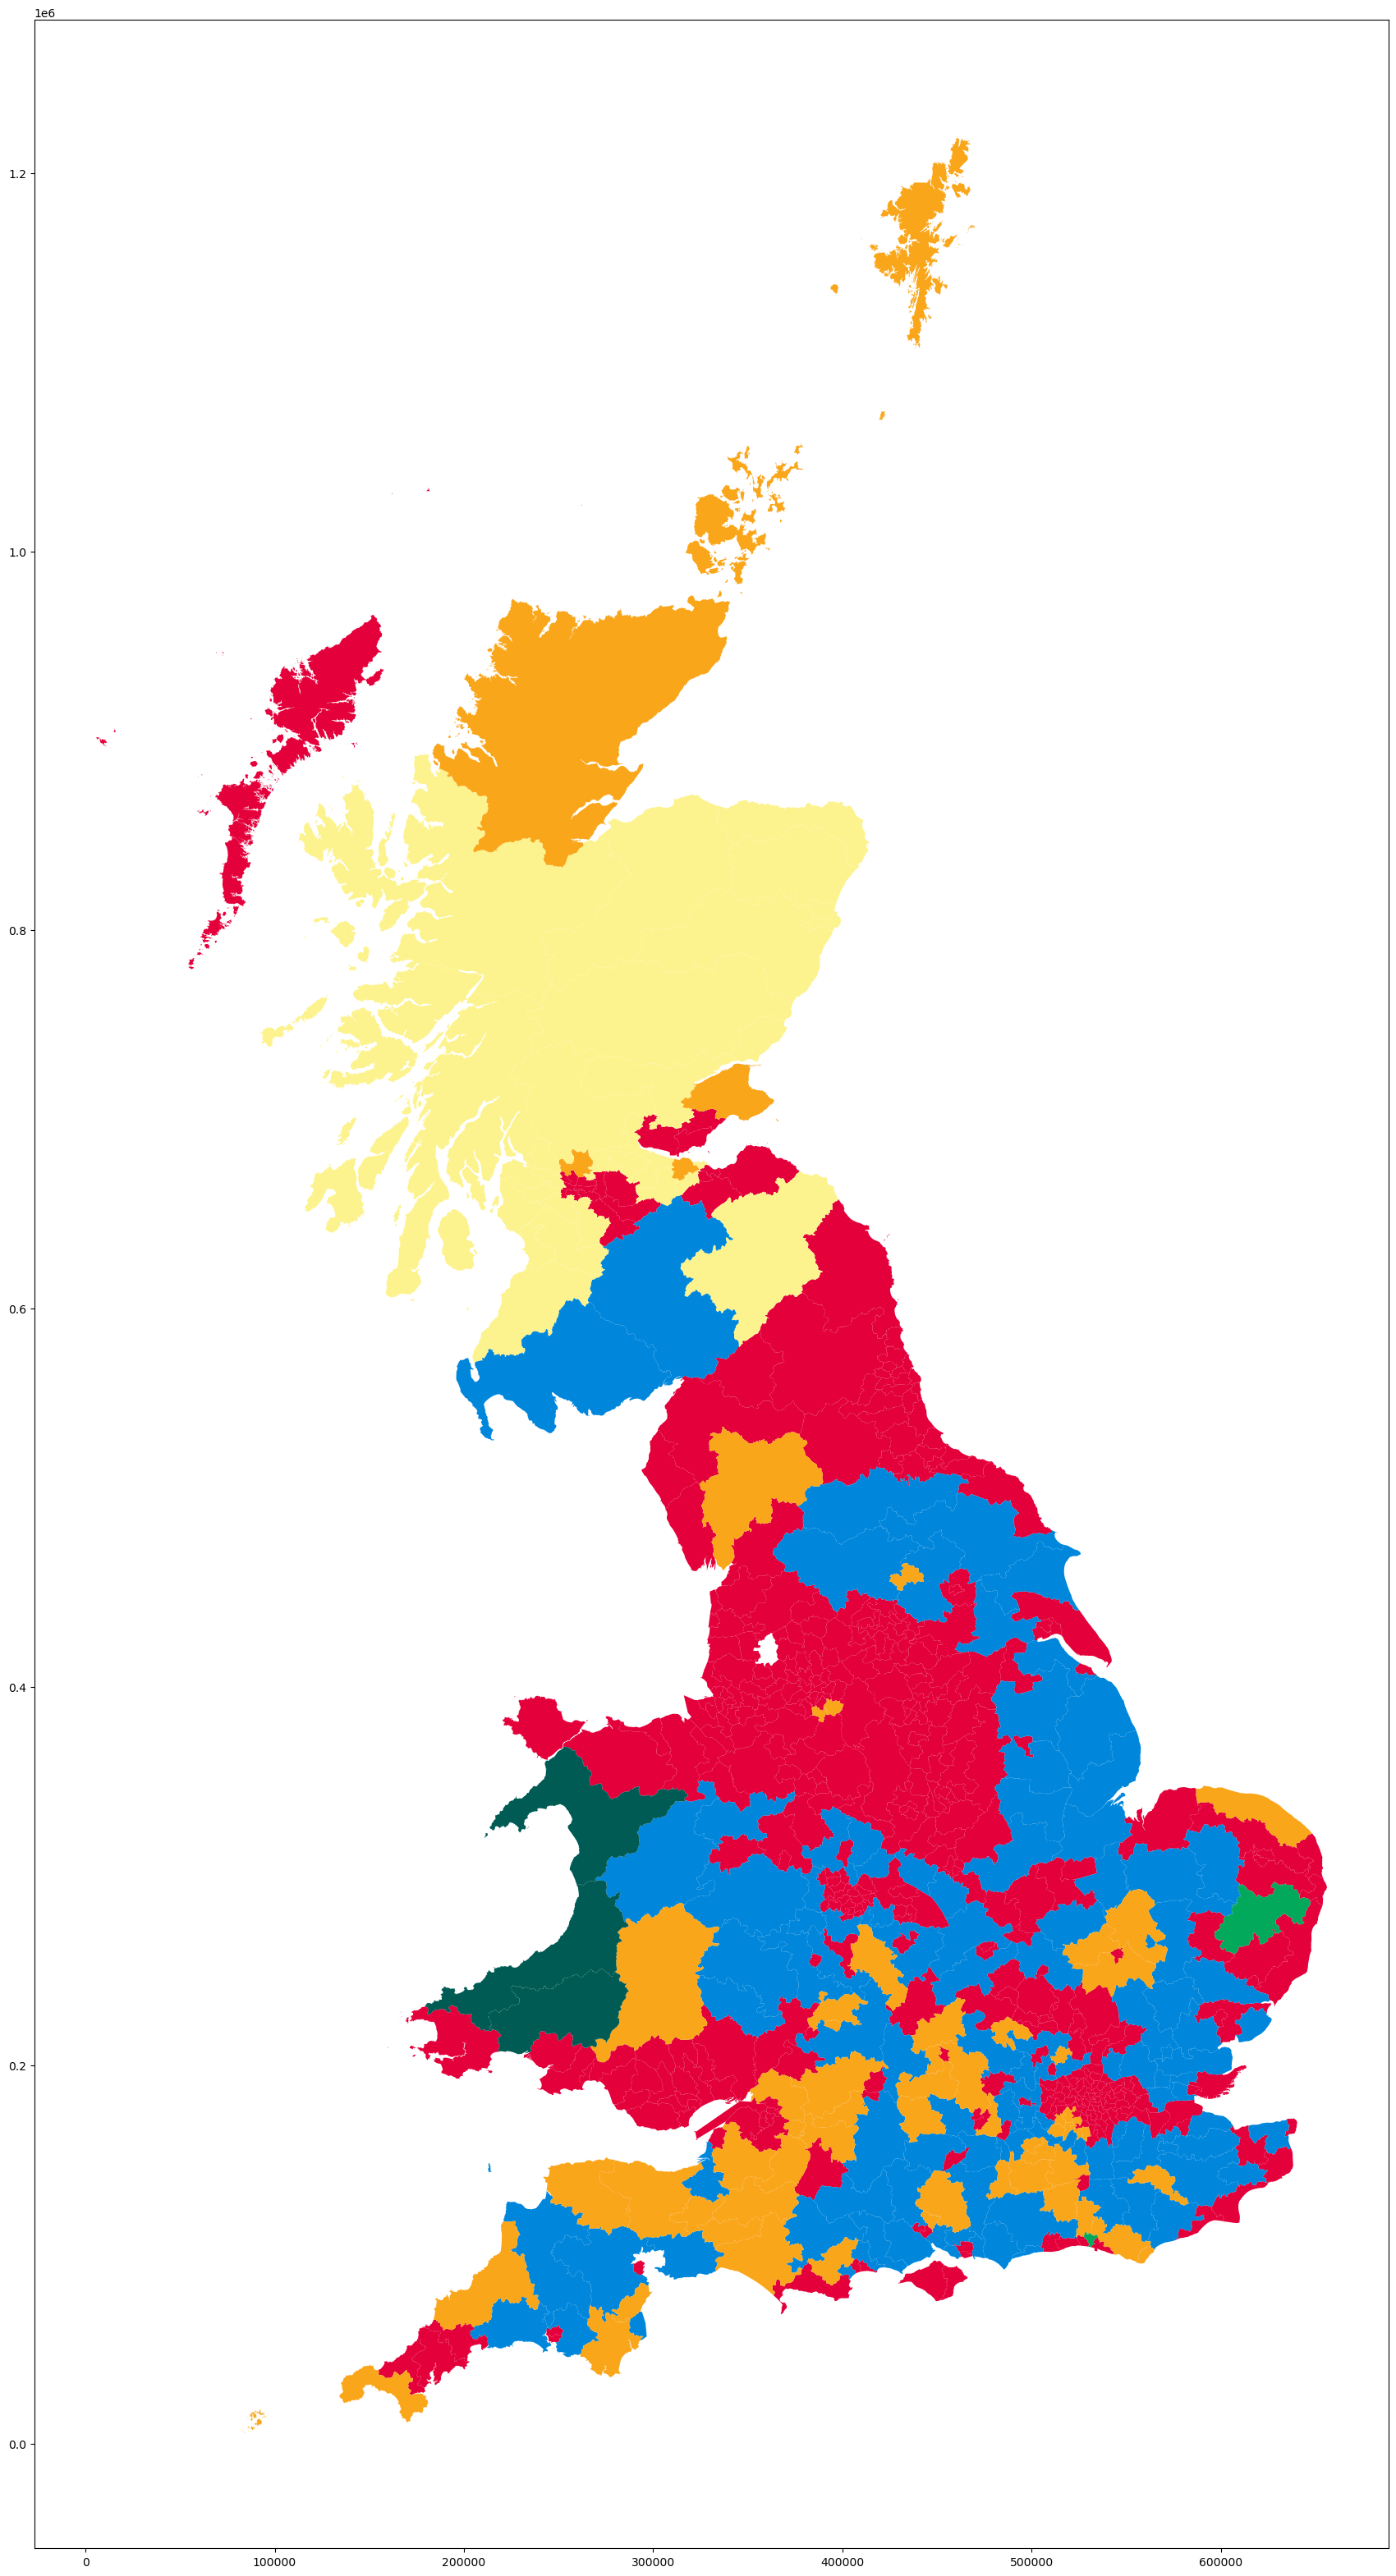

In [51]:
ax = df.plot(color="none", figsize=(40,40), edgecolor="none")
for party in df["LR Winner"].unique():
    df[df["LR Winner"] == party].plot(ax=ax, color=party_colours[party], edgecolor="none")

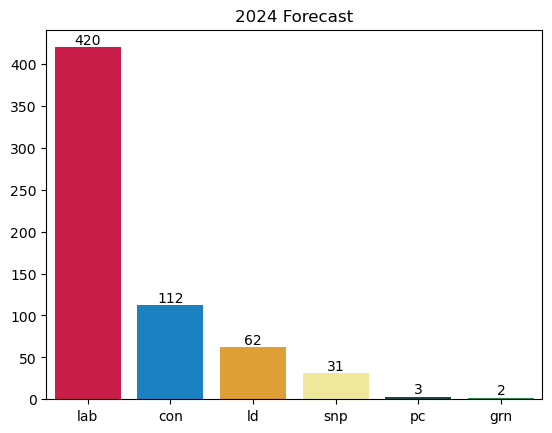

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

colours = sns.color_palette(list(party_colours.values()))
ordered_colours = {}
for party in df["LR Winner"].value_counts().index:
    ordered_colours[party] = party_colours[party]

ax = sns.barplot(y=df["LR Winner"].value_counts().values, x=list(df["LR Winner"].value_counts().index), hue=df["LR Winner"].value_counts().index, palette=ordered_colours, legend=False)
ax.set_title("2024 Forecast")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()